In [1]:
"""
PREDICTION LOOP:
Input: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,
                                                                  Period,
                                                                  Distribution,
                                                                  Price per volume,
                                                                  Price per volume without promo,
                                                                  Number of Categories,
                                                                  Number of Sub Categories,
                                                                  Category,
                                                                  Sub Category,
                                                                  Brand,
                                                                  }
Output: Predictions over 3Y + Sum over 3Y

"""

'\nPREDICTION LOOP:\nInput: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,\n                                                                  Period,\n                                                                  Distribution,\n                                                                  Price per volume,\n                                                                  Price per volume without promo,\n                                                                  Number of Categories,\n                                                                  Number of Sub Categories,\n                                                                  Category,\n                                                                  Sub Category,\n                                                                  Brand,\n                                                                  }\nOutput: Predictions over 3Y + Sum over 3Y\n\n'

In [76]:
import pickle
import json
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

In [3]:
PATH_TO_INPUTS = 'assets/'

In [29]:
from sklearn.neighbors import NearestNeighbors

In [126]:
from datamanager.DM_USA import DM_USA

with open('assets/params.json', 'r') as f:
    json_sell_out_params = json.load(f)

data_manager=DM_USA()
data_manager.ad_hoc_USA(json_sell_out_params)
df = data_manager.get_df()

In [127]:
#set space for nn
df_temp = df.copy()

In [128]:
def build_train_set(df):
    df_temp = df.copy()
    df_temp = df_temp[["Category", "Sub Category", "Brand", "Distribution", "Price per volume", "Sales in volume"]]

    df_n_cat = df_temp.groupby(['Brand'])['Category'].agg(Number_of_Categories = "nunique").reset_index().rename(columns={'Number_of_Categories':'Number of Categories'})
    df_n_sub_cat = df_temp.groupby(['Brand', 'Category'])['Sub Category'].agg(Sub_Categories='nunique').reset_index().rename(columns={'Sub_Categories':'Number of Sub Categories'})

    df_temp = pd.merge(df_temp, df_n_cat, on="Brand", how="left")
    df_temp = pd.merge(df_temp, df_n_sub_cat, on=["Brand", 'Category'], how="left")

    df_sub = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()

    """compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
    Distribution = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
        {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
    )

    Price = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
        {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
    )

    """merge high level metrics into df_sub"""
    df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

    df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])

    df_sub = df_sub.fillna(0.0)
    
    return df_sub

In [129]:
df_sub = build_train_set(df_temp)

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/1976902453.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()


In [151]:
df_sub.columns

Index(['Category', 'Sub Category', 'Brand', 'Number of Categories',
       'Number of Sub Categories', 'min Distribution', 'max Distribution',
       'mean Distribution', 'std Distribution', 'min Price', 'max Price',
       'mean Price', 'std Price'],
      dtype='object')

In [131]:
le_cat = LabelEncoder()
df_sub['Category'] = le_cat.fit_transform(df_sub['Category'])
le_sub_cat = LabelEncoder()
df_sub['Sub Category'] = le_sub_cat.fit_transform(df_sub['Sub Category'])
le_brand = LabelEncoder()
df_sub['Brand'] = le_brand.fit_transform(df_sub['Brand'])

In [132]:
neigh = NearestNeighbors(n_neighbors=30, radius=0.4)
neigh.fit(df_sub)

NearestNeighbors(n_neighbors=30, radius=0.4)

In [138]:
def build_profile(neighbors, df_sub, df, le_brand, le_cat, le_sub_cat):
    df_temp = df_sub.iloc[neighbors]
    df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
    df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
    df_temp['Brand'] = le_brand.inverse_transform(df_temp['Brand'])
    df_merge = pd.merge(df_temp[['Category', 'Sub Category', 'Brand']], df, on=['Category', 'Sub Category', 'Brand'], how='left')
    profile = df_merge.groupby('Date')['Sales in volume'].agg('mean')
    return profile
    #display(df_temp)



In [150]:
target = targets.get('0')
target

{'Brand': 'BABYBEL',
 'Category': 'CLASSIC SPREADS',
 'Sub Category': 'CLASSIC SPREADS',
 'Number of Categories': 2,
 'Number of Sub Categories': 1.0,
 'Date': '2022-01-01',
 'Period': 1,
 'Distribution': 3.828248441009294,
 'Price per volume': 8.428889363673324,
 'Price per volume without promo': 8.59811346519187}

In [4]:
"""Classifier, Forecaster"""
#classifier = pickle.load(open(PATH_TO_INPUTS + 'USA_classifier_7.sav', 'rb'))

forecaster = lgb.Booster(model_file=PATH_TO_INPUTS + 'USA_forecaster_7.txt')

In [5]:
"""Profiles"""
profiles = pd.read_csv(PATH_TO_INPUTS+"USA_profiles_7.csv")

In [259]:
"""Label Encoders"""
le_brand_forecast = pickle.load(open(PATH_TO_INPUTS + 'USA_encoder_brand_7.pkl', 'rb'))
le_sub_cat_forecast = pickle.load(open(PATH_TO_INPUTS + 'USA_encoder_sub_cat_7.pkl', 'rb'))
le_cat_forecast = pickle.load(open(PATH_TO_INPUTS + 'USA_encoder_cat_7.pkl', 'rb'))

In [188]:
"""Targets"""
# with open(PATH_TO_INPUTS + 'predictions_targets_USA.json', 'r') as f:
#         targets = json.load(f)['targets']

# target = targets[1]



In [260]:
def create_left_inputs(static_inputs):
    """
    """
    dt = static_inputs['Date']
    pd_dt = pd.Timestamp(dt)
    
    second_left_inputs = [static_inputs['Distribution'], 
                          static_inputs['Price per volume'], 
                          #static_inputs['Price per volume without promo'], 
                          static_inputs['Number of Categories'], 
                          static_inputs['Number of Sub Categories']]
    
    left_inputs_bis = [static_inputs['Category'],
                       static_inputs['Sub Category'],
                       static_inputs['Brand']]

    left_inputs = [static_inputs['Period'],
                   pd_dt.weekofyear, 
                   pd_dt.is_month_end, 
                   pd_dt.is_month_start] + left_inputs_bis + second_left_inputs
    
    return left_inputs

def update_sample_and_forecast(xgb, sales_lag, 
                               roll_mean, lags, alphas, 
                               static_inputs, period=39, weeks_per_period=1):
    """
    """

    forecasts, samples = [], []
    len_lags = len(lags)
    index_lags = [l-1 for l in lags]
        
    tdelta = dt.timedelta(weeks=weeks_per_period)
    static_inputs['Date'] += tdelta
    left_inputs = create_left_inputs(static_inputs)
    #right_inputs = create_ohe_inputs(*cat_info, ohe_columns=ohe_columns)
    sales_lag = np.log1p(sales_lag)
    
    for p in range(period):
        sales_roll_mean = []
        sales_emw = {alpha:[] for alpha in alphas}
        
        # Compute Roll mean
        for rm in roll_mean:
            df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1).rolling(rm, min_periods=2, win_type="triang").mean()) #+ random_noise(df)
            sales_roll_mean.append(df_tmp.iloc[rm-1].values[0])
            
        # Compute EMW
        for k in alphas:
            for lag in lags:
                df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1*lag).ewm(alpha=k).mean())
                sales_emw[k].append(df_tmp.iloc[0].values[0])
                
        # Concat Sample with static inputs, roll mean, emw, and one hot encodings
        sample = left_inputs + sales_lag[index_lags].tolist() + sales_roll_mean
        for k in alphas:
            sample += sales_emw[k]
        #sample += right_inputs
                
        # Predict next month sales using XGB
        #print(sample)
        #print([x for x in forecaster.feature_name() if x not in sample])
        sales_hat = xgb.predict(np.expand_dims(sample, 0))[0]
        
        samples.append(sample)
    
        sales_lag = np.insert(sales_lag, 0, sales_hat)
        sales_lag = sales_lag[:-1]
        
        sales_hat = np.expm1(sales_hat)
        forecasts.append(sales_hat)

        static_inputs['Period'] += 1
        static_inputs['Date'] += tdelta
        left_inputs = create_left_inputs(static_inputs)
        
    #df_forecasts = pd.DataFrame(np.hstack((np.array(samples), np.array(forecasts)[:, np.newaxis])), columns=list(X_train.columns) + ['Y'])
    df_forecasts = np.array(forecasts)
    return df_forecasts

In [274]:
def pred(forecaster, profile, le_brand, le_cat, le_sub_cat, target):
    """Find cluster and profile
    """
    """Predict
    """
    target['Date'] = dt.datetime.fromisoformat(target['Date'])
    target['Brand'] = le_brand.transform([target['Brand']])
    target['Category'] = le_cat.transform([target['Category']])
    target['Sub Category'] = le_sub_cat.transform([target['Sub Category']])

    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
    alphas_list = [0.95, 0.9, 0.8, 0.7, 0.5]

    #profile = profiles[i]
    #profile = profiles[str(int(cluster[0]))]
    
    forecasts = update_sample_and_forecast(forecaster, profile.values[::-1],
                            primes, primes, alphas_list, 
                            target, period=157, weeks_per_period=1)
    sns.lineplot(data=forecasts)
    #plt.show()

    return forecasts.sum()

1
{'Category': 16, 'Sub Category': 4, 'Brand': 1453, 'Number of Categories': 3, 'Number of Sub Categories': 1.0, 'min Distribution': 22.557441, 'max Distribution': 104.356422, 'mean Distribution': 55.87015, 'std Distribution': 21.537048, 'min Price': 7.045595, 'max Price': 10.824979, 'mean Price': 9.082848, 'std Price': 0.767633}


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3818415912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3818415912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3818415912.py:5: SettingWithCopyWarning: 
A

1680025.2601601318


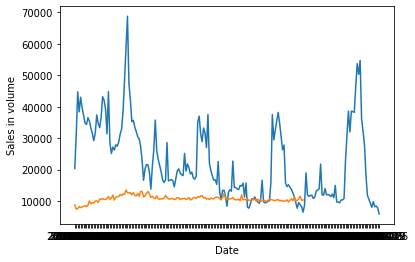

200
{'Category': 16, 'Sub Category': 4, 'Brand': 1453, 'Number of Categories': 3, 'Number of Sub Categories': 1.0, 'min Distribution': 22.557441, 'max Distribution': 104.356422, 'mean Distribution': 55.87015, 'std Distribution': 21.537048, 'min Price': 7.045595, 'max Price': 10.824979, 'mean Price': 9.082848, 'std Price': 0.767633}


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3818415912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3818415912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3818415912.py:5: SettingWithCopyWarning: 
A

1590902.4685459514


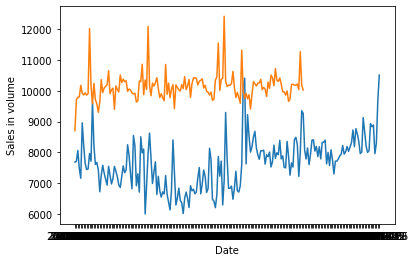

In [279]:
with open('assets/USA_targets_7.json', 'r') as f:
        targets = json.load(f)
#for key in targets:
for i in [1, 200]:
        #i=200
        print(i)
        #print(f'{targets.get(key).get("Brand")}, {targets.get(key).get("Category")}')
        target = targets.get('99').copy()

        # p = {
        #         'Category':le_cat.transform([target.get('Category')])[0],
        #         'Sub Category':le_sub_cat.transform([target.get('Sub Category')])[0],
        #         'Brand':le_brand.transform([target.get('Brand')])[0],
        #         'Number of Categories':target.get('Number of Categories'),
        #         'Number of Sub Categories':target.get('Number of Sub Categories'),
        #         'min Distribution':target.get('Distribution') - (target.get('Distribution')*1/20),
        #         'max Distribution':target.get('Distribution') + (target.get('Distribution')*1/20),
        #         'mean Distribution':target.get('Distribution'),
        #         'std Distribution':(target.get('Distribution')*1/100),
        #         'min Price':target.get('Price per volume') - (target.get('Price per volume')*1/20),
        #         'max Price':target.get('Price per volume') + (target.get('Price per volume')*1/20),
        #         'mean Price':target.get('Price per volume'),
        #         'std Price':(target.get('Price per volume')*1/100),
        # }
        p = {
                'Category':le_cat.transform(['SNACKING COMBOS'])[0],
                'Sub Category':le_sub_cat.transform(['CHEESE DIPPER COMBOS'])[0],
                'Brand':le_brand.transform(['THE LAUGHING COW'])[0],
                'Number of Categories':target.get('Number of Categories'),
                'Number of Sub Categories':target.get('Number of Sub Categories'),
                'min Distribution':22.557441,
                'max Distribution':104.356422,
                'mean Distribution':55.870150,
                'std Distribution':21.537048,
                'min Price':7.045595,
                'max Price':10.824979,
                'mean Price':9.082848,
                'std Price':0.767633,
        }

        print(p)
        p = pd.DataFrame(p, index=[0])

        neighbors = neigh.kneighbors(p, i, return_distance=False)
        profile = build_profile(neighbors[0], df_sub, df_temp, le_brand, le_cat, le_sub_cat)
        sns.lineplot(data=profile)
        
        #plt.show()
        #moyenne des ventes de mes voisins

        forecasts = pred(forecaster, profile, le_brand_forecast, le_cat_forecast, le_sub_cat_forecast, target)
        print(forecasts)
        plt.show()
        
        #targets[key]['3Y'] = forecasts
        
        
        

In [264]:
df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']
for key, target in targets.items():
    if target.get('Brand') == 'BABYBEL':
        #print(key)
        if target.get('Category')=='SNACK':
            print(key)
            # if target.get('Sub Category')=='CHEESE DIPPER COMBOS':
            #     print(key)
            #print(le_cat.inverse_transform(target.get('Category')))

13


/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3553842511.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']


In [257]:
targets.get('99')

{'Brand': 'THE LAUGHING COW',
 'Category': 'SNACKING COMBOS',
 'Sub Category': 'CHEESE COMBO WITH MEAT PROTEIN',
 'Number of Categories': 3,
 'Number of Sub Categories': 1.0,
 'Date': '2022-01-01',
 'Period': 1,
 'Distribution': 42.160040802065375,
 'Price per volume': 12.135157741532264,
 'Price per volume without promo': 12.72}

In [13]:
pred = [{'Brand':le_brand.inverse_transform(targets.get(x).get('Brand')), 
         'Category':le_cat.inverse_transform(targets.get(x).get('Category')), 
         '3Y':targets.get(x).get('3Y'),
         'cluster':targets.get(x).get('cluster')
         } for x in targets]

In [23]:
def make_pretty(styler):
    styler.background_gradient(axis=None)
    return styler


#df_corr.style.pipe(make_pretty)
df_pred = pd.DataFrame(pred)
df_pred['Brand'] = df_pred['Brand'].apply(lambda x:x[0])
df_pred['Category'] = df_pred['Category'].apply(lambda x:x[0])
df_pred['3Y'] = df_pred['3Y'].apply(lambda x:x/1000)
y_pred = df_pred.pivot_table(values='3Y', columns='Category', index='Brand')
y_pred.style.pipe(make_pretty)

Category,CLASSIC SPREADS,CREAM CHEESE,CREAM CHEESE TUBS,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS
Brand,,,,,,,,,,,,,,,,,
BABYBEL,11547.339175,19611.634149,13425.991125,13740.917010,13545.101943,19617.840262,14158.135979,14279.271299,14539.494991,29684.118036,14100.730317,16457.987730,14123.619054,15327.414706,19701.192300,16470.910745,18665.865197
BOURSIN,12365.449439,19360.579971,13999.157570,14385.547602,14013.588339,19428.905901,14393.458615,14755.795711,15352.367399,28046.538014,14684.752542,16462.046537,14806.944447,15948.542133,20451.895640,16804.999337,19880.897498
KAUKAUNA,11468.758708,17500.041845,13105.526527,13030.006966,12859.968969,16249.084846,13250.495725,13481.483972,13360.104724,14722.104669,13224.585637,14300.439152,13524.232438,14900.715202,17022.076554,14178.014396,14416.256101
MERKTS,11814.516437,17541.513718,13639.245376,13696.538702,13569.064540,18016.651919,13848.987434,13962.103560,14137.733905,18267.554934,13826.700068,14909.604499,14212.554746,14675.685232,17556.421474,15527.517185,16365.964791
NURISHH,11490.782008,19873.753594,13841.997211,13816.995487,13449.211288,19750.382050,14238.869870,14416.309362,14467.448494,25399.684128,14201.136316,15748.588678,14358.326266,15125.733994,19226.387546,16761.742107,19493.050054
PRICES,10248.168948,19409.450457,13273.782100,13776.998550,13416.449039,20626.418104,14085.186060,14411.768172,14394.503813,25220.175946,14076.139873,16212.427871,14535.379944,14814.002415,19223.583208,17463.446966,19742.472700
THE LAUGHING COW,9495.845391,18372.588364,11420.026280,11471.558505,11348.724106,18382.121941,11308.012239,11265.072093,13487.577940,21807.244811,11002.297200,14267.765981,11434.231082,13931.736494,18253.676288,13138.802770,13815.030782


In [16]:

#df_pred.to_excel('view/' + 'USA_pred_3Y_7.xlsx')

In [19]:
df = data_manager.get_df()
bel_brands = json_sell_out_params.get('USA').get('bel_brands')
y_true=pd.pivot_table(df[df.Brand.isin(bel_brands)], values='Sales in volume', columns='Category', index='Brand', aggfunc='sum')
y_true = y_true.div(1000)

In [20]:
y_true

Category,CLASSIC SPREADS,GOURMET SPREADS,PIMENTO,PLANT BASED,SNACK,SNACKING COMBOS
Brand,,,,,,
BABYBEL,NaN,NaN,NaN,NaN,80524.784584,1371.573001
BOURSIN,NaN,10885.120322,NaN,42.458153,NaN,NaN
KAUKAUNA,8785.860921,19864.362112,NaN,NaN,67.611856,NaN
MERKTS,12600.546467,NaN,NaN,NaN,62.651540,NaN
NURISHH,NaN,NaN,NaN,8.775062,NaN,NaN
PRICES,NaN,NaN,23719.733877,NaN,18.953260,NaN
THE LAUGHING COW,67.794016,NaN,NaN,NaN,46407.430180,4714.037257


In [273]:
4714.037257/4

1178.50931425

In [28]:
#y_pred[~y_true.isna()] = None
(y_pred + y_pred.multiply(1/3))

Category,CLASSIC SPREADS,CREAM CHEESE,CREAM CHEESE TUBS,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS
Brand,,,,,,,,,,,,,,,,,
BABYBEL,15396.452233,26148.845532,17901.321499,18321.222680,18060.135924,26157.120349,18877.514638,19039.028398,19385.993322,39578.824048,18800.973756,21943.983639,18831.492072,20436.552941,26268.256400,21961.214326,24887.820263
BOURSIN,16487.265919,25814.106628,18665.543427,19180.730135,18684.784452,25905.207868,19191.278153,19674.394281,20469.823199,37395.384019,19579.670056,21949.395382,19742.592595,21264.722844,27269.194187,22406.665783,26507.863330
KAUKAUNA,15291.678278,23333.389127,17474.035369,17373.342621,17146.625292,21665.446461,17667.327634,17975.311962,17813.472965,19629.472892,17632.780849,19067.252203,18032.309917,19867.620270,22696.102072,18904.019194,19221.674801
MERKTS,15752.688583,23388.684957,18185.660501,18262.051603,18092.086053,24022.202559,18465.316579,18616.138080,18850.311873,24356.739912,18435.600091,19879.472665,18950.072994,19567.580310,23408.561965,20703.356246,21821.286389
NURISHH,15321.042677,26498.338125,18455.996281,18422.660649,17932.281718,26333.842734,18985.159826,19221.745816,19289.931326,33866.245504,18934.848422,20998.118237,19144.435021,20167.645325,25635.183394,22348.989476,25990.733405
PRICES,13664.225265,25879.267277,17698.376133,18369.331400,17888.598719,27501.890805,18780.248080,19215.690897,19192.671750,33626.901262,18768.186497,21616.570495,19380.506592,19752.003220,25631.444277,23284.595955,26323.296933
THE LAUGHING COW,12661.127188,24496.784486,15226.701706,15295.411339,15131.632142,24509.495921,15077.349652,15020.096124,17983.437253,29076.326415,14669.729600,19023.687974,15245.641443,18575.648658,24338.235050,17518.403693,18420.041043


In [25]:
y_pred

Category,CLASSIC SPREADS,CREAM CHEESE,CREAM CHEESE TUBS,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS
Brand,,,,,,,,,,,,,,,,,
BABYBEL,11547.339175,19611.634149,13425.991125,13740.917010,13545.101943,19617.840262,14158.135979,14279.271299,14539.494991,29684.118036,14100.730317,16457.987730,14123.619054,15327.414706,19701.192300,16470.910745,18665.865197
BOURSIN,12365.449439,19360.579971,13999.157570,14385.547602,14013.588339,19428.905901,14393.458615,14755.795711,15352.367399,28046.538014,14684.752542,16462.046537,14806.944447,15948.542133,20451.895640,16804.999337,19880.897498
KAUKAUNA,11468.758708,17500.041845,13105.526527,13030.006966,12859.968969,16249.084846,13250.495725,13481.483972,13360.104724,14722.104669,13224.585637,14300.439152,13524.232438,14900.715202,17022.076554,14178.014396,14416.256101
MERKTS,11814.516437,17541.513718,13639.245376,13696.538702,13569.064540,18016.651919,13848.987434,13962.103560,14137.733905,18267.554934,13826.700068,14909.604499,14212.554746,14675.685232,17556.421474,15527.517185,16365.964791
NURISHH,11490.782008,19873.753594,13841.997211,13816.995487,13449.211288,19750.382050,14238.869870,14416.309362,14467.448494,25399.684128,14201.136316,15748.588678,14358.326266,15125.733994,19226.387546,16761.742107,19493.050054
PRICES,10248.168948,19409.450457,13273.782100,13776.998550,13416.449039,20626.418104,14085.186060,14411.768172,14394.503813,25220.175946,14076.139873,16212.427871,14535.379944,14814.002415,19223.583208,17463.446966,19742.472700
THE LAUGHING COW,9495.845391,18372.588364,11420.026280,11471.558505,11348.724106,18382.121941,11308.012239,11265.072093,13487.577940,21807.244811,11002.297200,14267.765981,11434.231082,13931.736494,18253.676288,13138.802770,13815.030782


In [26]:
y_true

Category,CLASSIC SPREADS,GOURMET SPREADS,PIMENTO,PLANT BASED,SNACK,SNACKING COMBOS
Brand,,,,,,
BABYBEL,NaN,NaN,NaN,NaN,80524.784584,1371.573001
BOURSIN,NaN,10885.120322,NaN,42.458153,NaN,NaN
KAUKAUNA,8785.860921,19864.362112,NaN,NaN,67.611856,NaN
MERKTS,12600.546467,NaN,NaN,NaN,62.651540,NaN
NURISHH,NaN,NaN,NaN,8.775062,NaN,NaN
PRICES,NaN,NaN,23719.733877,NaN,18.953260,NaN
THE LAUGHING COW,67.794016,NaN,NaN,NaN,46407.430180,4714.037257


In [ ]:
#data_manager.df[data_manager.df.Brand.isin(bel_brands)].groupby(['Brand', 'Category'])['Sales in volume'].agg('sum')/1000

Brand             Category                  
BABYBEL           SNACK                         80524.784584
                  SNACKING COMBOS                1371.573001
BOURSIN           GOURMET                       10885.298255
                  PLANT BASED                      42.458153
KAUKAUNA          CLASSIC SPREADS                8785.860921
                  GOURMET                       19863.413786
                  SNACK                            67.611856
MERKTS            CLASSIC SPREADS               12600.546467
                  SNACK                            62.651540
NURISHH           EVERYDAY SHREDDED & GRATED        4.457501
                  PLANT BASED                       8.775062
                  SLICES                            4.317561
PRICES            PIMENTO                       23719.733877
                  SNACK                            18.953260
THE LAUGHING COW  CLASSIC SPREADS                  67.794016
                  PLANT BASED           

In [280]:
time_serie = df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']['Sales in volume']

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/595029084.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  time_serie = df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']['Sales in volume']


In [271]:
df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS'][['Distribution', 'Price per volume']].agg('std')

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3599048565.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS'][['Distribution', 'Price per volume']].agg('std')


Distribution        21.537048
Price per volume     0.767633
dtype: float64

In [282]:
time_serie.reset_index(drop=True)

0      20370.255253
1      31423.449508
2      44740.601942
3      38353.966531
4      43025.658107
           ...     
204     9814.594167
205     8207.155612
206     8376.817670
207     7787.803257
208     5896.800917
Name: Sales in volume, Length: 209, dtype: float64